In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=c372600992089aad7376d617ba5598a5d9a8207b84318d5923e414b9c79030b5
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
cd '/content/drive/MyDrive/BloodCellClassification'

/content/drive/MyDrive/BloodCellClassification


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils.models import cnn, dilated_cnn, vgg, autoencoder, autoclassifier, resnet34, inception, vgg12, vgg15, vgg18
from utils.training import train_adam, train_sgd, train_autoencoder
from medmnist import BloodMNIST

In [ ]:
# Define a function to get the label names
def label_name(label):
    names = ['Eosinophil', 'Basophil', 'Neutrophil', 'Lymphocyte', 'Monocyte', 'Platelet', 'RBC', 'Background']
    return names[label]

In [ ]:
# Load the dataset of the images using size 64
train_dataset = BloodMNIST(split='train', download=True, size=64)
val_dataset = BloodMNIST(split='val', download=True, size=64)
test_dataset = BloodMNIST(split='test', download=True, size=64)

100%|██████████| 156M/156M [00:08<00:00, 18.2MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz


## For Supervised Learning

In [ ]:
# Convert the datasets into tf.data.Dataset format
def create_tf_dataset(medmnist_dataset):
    images = []
    labels = []

    # Collect images and labels
    for img, label in medmnist_dataset:
        images.append(img)
        labels.append(label)

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Create TensorFlow dataset
    return tf.data.Dataset.from_tensor_slices((images, labels))

In [ ]:
# Convert MedMNIST datasets to TensorFlow datasets
train_tf_dataset = create_tf_dataset(train_dataset)
val_tf_dataset = create_tf_dataset(val_dataset)
test_tf_dataset = create_tf_dataset(test_dataset)

In [ ]:
# Function to preprocess the images (convert to Tensor and normalize)
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
# Apply preprocessing to the datasets
train_tf_dataset = train_tf_dataset.map(preprocess_image)
val_tf_dataset = val_tf_dataset.map(preprocess_image)
test_tf_dataset = test_tf_dataset.map(preprocess_image)

# Batch the datasets
batch_size = 128
train_tf_dataset = train_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_tf_dataset = val_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_tf_dataset = test_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

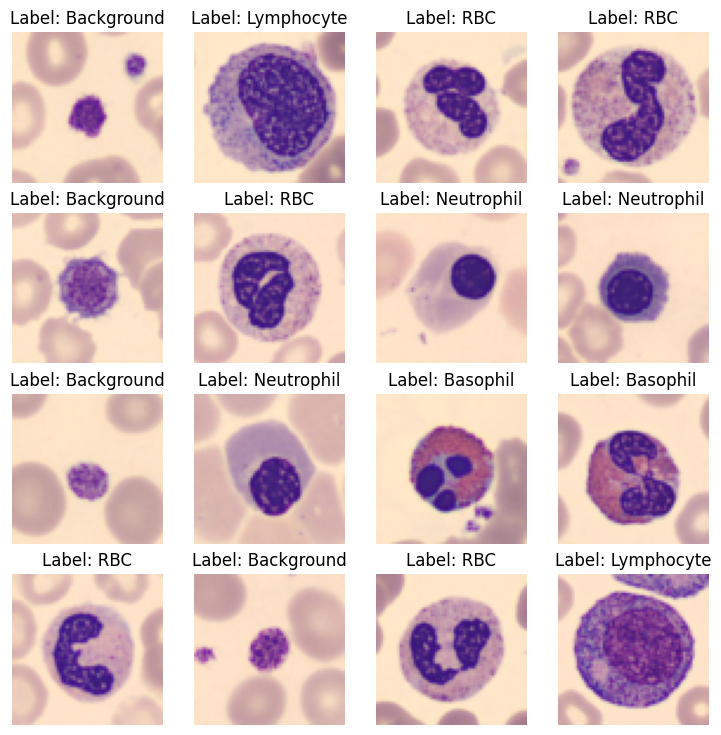

In [ ]:
# Visualize a batch of training data
for images, labels in train_tf_dataset.take(1):
    # Plot images (display first 16 images in the batch)
    plt.figure(figsize=(9, 9))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy())  # Convert tensor to numpy for plotting
        plt.title(f"Label: {label_name(labels[i].numpy()[0])}")
        plt.axis('off')
    plt.show()

## For the autoencoder

In [ ]:
def preprocess_dataset(dataset):
    # Adjust this based on dataset structure
    try:
        images = dataset.images  # Use correct attribute if available
    except AttributeError:
        images = [dataset[i][0] for i in range(len(dataset))]  # Extract images manually

    # Normalize images to [0, 1]
    images = np.array(images) / 255.0  # Convert to NumPy if not already
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Create (input, target) pairs
    dataset = tf.data.Dataset.from_tensor_slices((images, images))
    return dataset

# Preprocess datasets
train_autoencoder_dataset = preprocess_dataset(train_dataset)
val_autoencoder_dataset = preprocess_dataset(val_dataset)
test_autoencoder_dataset = preprocess_dataset(test_dataset)

# Batch the datasets
batch_size = 64  # Define your batch size
train_autoencoder_dataset = train_autoencoder_dataset.batch(batch_size, drop_remainder=True)
val_autoencoder_dataset = val_autoencoder_dataset.batch(batch_size, drop_remainder=True)
test_autoencoder_dataset = test_autoencoder_dataset.batch(batch_size, drop_remainder=True)

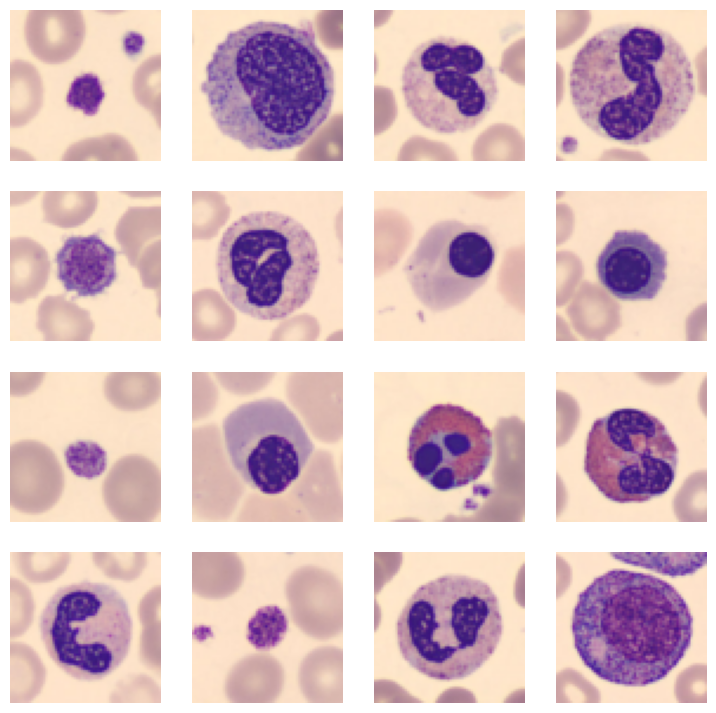

In [ ]:
# Visualize a batch of training data
for images_1, images_2 in train_autoencoder_dataset.take(1):
    # Plot images (display first 16 images in the batch)
    plt.figure(figsize=(9, 9))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images_1[i].numpy())  # Convert tensor to numpy for plotting
        plt.axis('off')
    plt.show()

# Data Balance
Note for myself, I only did this for the training set, I would have to to it for the validation and test sets as well.

In [ ]:
# Extract all the labels from the dataset
all_labels_train = []
all_labels_val = []
all_labels_test = []

for _, label in train_dataset:
  label_number = tuple(label)[0]
  all_labels_train.append(label_name(label_number))

for _, label in val_dataset:
  label_number = tuple(label)[0]
  all_labels_val.append(label_name(label_number))
for _, label in test_dataset:
  label_number = tuple(label)[0]
  all_labels_test.append(label_name(label_number))

# Count instances per class
class_counts_train = Counter(all_labels_train)
print("Class Counts train dataset:", class_counts_train)

class_counts_val = Counter(all_labels_val)
print("Class Counts validation dataset:", class_counts_val)

class_counts_test = Counter(all_labels_test)
print("Class Counts test dataset:", class_counts_test)

# Calculate proportions
classes_train, counts_train = zip(*sorted(class_counts_train.items()))
total_samples_train = sum(counts_train)
class_proportions_train = {cls: count_train / total_samples_train for cls, count_train in class_counts_train.items()}
print("Class Proportions in Training Set:", class_proportions_train)

classes_val, counts_val = zip(*sorted(class_counts_val.items()))
total_samples_val = sum(counts_val)
class_proportions_val = {cls: count_val / total_samples_val for cls, count_val in class_counts_val.items()}
print("Class Proportions in Validation Set:", class_proportions_val)

classes_test, counts_test = zip(*sorted(class_counts_test.items()))
total_samples_test = sum(counts_test)
class_proportions_test = {cls: count_test / total_samples_test for cls, count_test in class_counts_test.items()}
print("Class Proportions in Test Set:", class_proportions_test)

Class Counts train dataset: Counter({'RBC': 2330, 'Basophil': 2181, 'Lymphocyte': 2026, 'Background': 1643, 'Neutrophil': 1085, 'Platelet': 993, 'Eosinophil': 852, 'Monocyte': 849})
Class Counts validation dataset: Counter({'RBC': 333, 'Basophil': 312, 'Lymphocyte': 290, 'Background': 235, 'Neutrophil': 155, 'Platelet': 143, 'Monocyte': 122, 'Eosinophil': 122})
Class Counts test dataset: Counter({'RBC': 666, 'Basophil': 624, 'Lymphocyte': 579, 'Background': 470, 'Neutrophil': 311, 'Platelet': 284, 'Eosinophil': 244, 'Monocyte': 243})
Class Proportions in Training Set: {'Background': 0.1373860690693202, 'Lymphocyte': 0.16941215820720795, 'RBC': 0.1948323438414583, 'Neutrophil': 0.09072664938540012, 'Basophil': 0.182373108119408, 'Platelet': 0.08303369846977172, 'Eosinophil': 0.07124341500125428, 'Monocyte': 0.07099255790617945}
Class Proportions in Validation Set: {'Monocyte': 0.07126168224299065, 'Eosinophil': 0.07126168224299065, 'Background': 0.13726635514018692, 'RBC': 0.19450934579

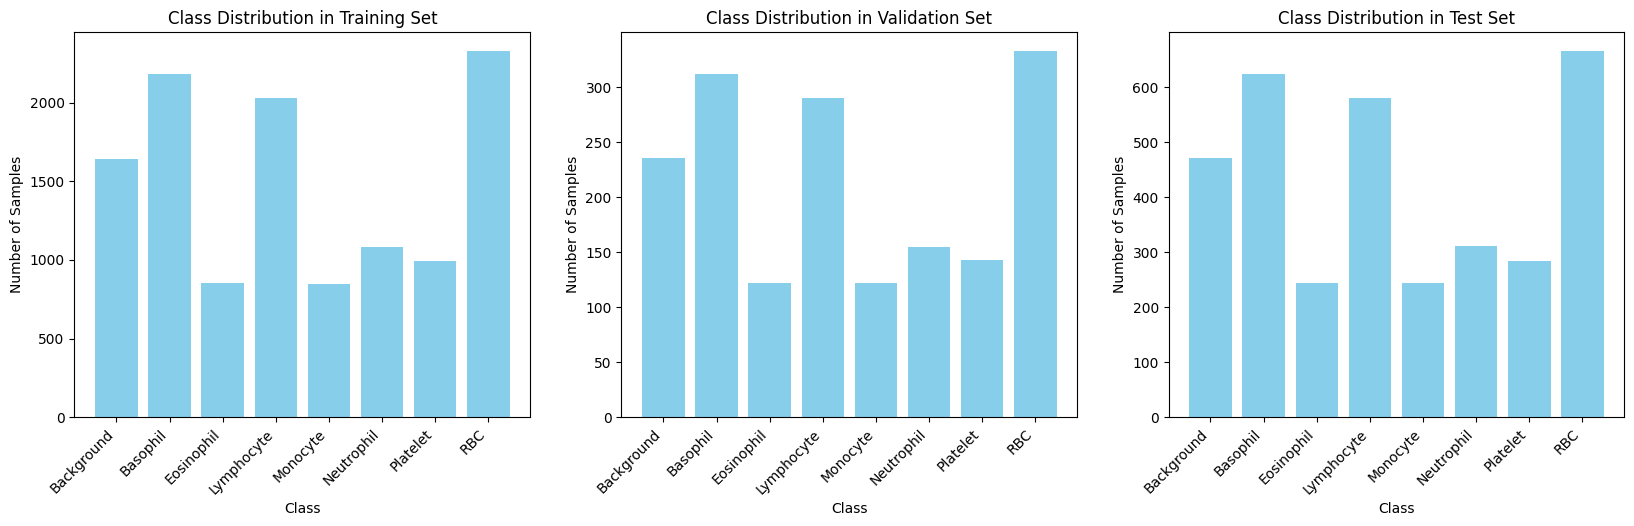

In [ ]:
plt.figure(figsize=(20, 5))

# Display Class Distribution Training Set
plt.subplot(1, 3, 1)
plt.bar(classes_train, counts_train, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')

# Display Class Distribution Validation Set
plt.subplot(1, 3, 2)
plt.bar(classes_val, counts_val, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Validation Set')

# Display Class Distribution Validation Set
plt.subplot(1, 3, 3)
plt.bar(classes_test, counts_test, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Test Set')

plt.show()

## Data Augmentation

FISRT ATTEMPT:

In [ ]:
X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

for img, label in train_dataset:
    X_train.append(img)
    Y_train.append(label)

for img, label in val_dataset:
    X_val.append(img)
    Y_val.append(label)

for img, label in test_dataset:
    X_test.append(img)
    Y_test.append(label)

# Convert to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize the data
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Create an ImageDataGenerator with data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=15,          # Rotate the image by up to 15 degrees
    width_shift_range=0.1,      # Shift the width by up to 10% of the image width
    height_shift_range=0.1,     # Shift the height by up to 10% of the image height
    zoom_range=0.1,             # Zoom in by up to 10%
    horizontal_flip=True        # Randomly flip images horizontally
)

# Fit the ImageDataGenerator to the training data
datagen.fit(images)

In [ ]:
X_train = images.reshape(images.shape[0], 64, 64, 3)
X_train.shape

(11959, 64, 64, 3)

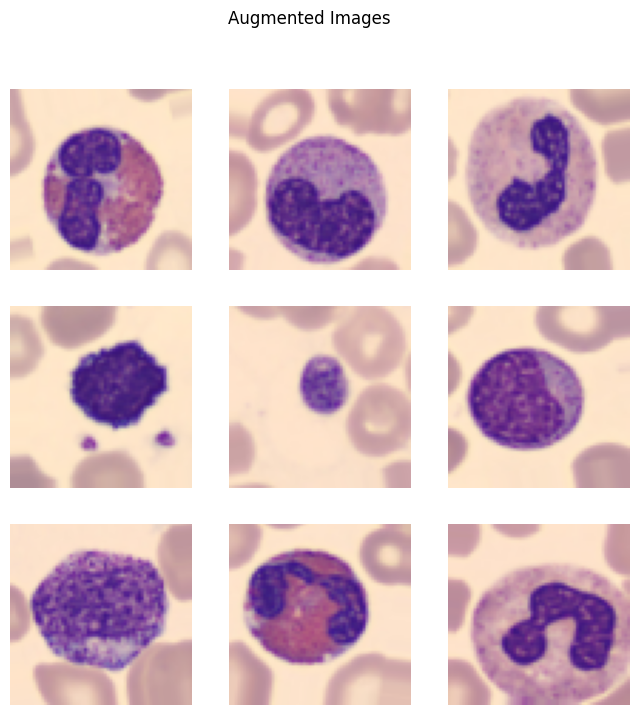

In [ ]:
images = []
labels = []

for img, label in train_dataset:
    images.append(img)  # Convert tf.Tensor to NumPy array
    labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the data
images = images.astype('float32') / 255.0

# Create an ImageDataGenerator with data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=15,          # Rotate the image by up to 15 degrees
    width_shift_range=0.1,      # Shift the width by up to 10% of the image width
    height_shift_range=0.1,     # Shift the height by up to 10% of the image height
    zoom_range=0.1,             # Zoom in by up to 10%
    horizontal_flip=True        # Randomly flip images horizontally
)

# Fit the ImageDataGenerator to the training data
datagen.fit(images)

# Let's visualize some augmented images
for X_batch, y_batch in datagen.flow(images, labels, batch_size=9):
    # Create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(9):
        ax[i//3, i%3].imshow(X_batch[i])
        ax[i//3, i%3].axis('off')
    plt.suptitle('Augmented Images')
    plt.show()
    break  # Only show one batch


SECOND ATTEMPT:

Generating 1478 images for class Eosinophil...
Augmentation complete for class Eosinophil.
Generating 149 images for class Basophil...
Augmentation complete for class Basophil.
Generating 1245 images for class Neutrophil...
Augmentation complete for class Neutrophil.
Generating 304 images for class Lymphocyte...
Augmentation complete for class Lymphocyte.
Generating 1481 images for class Monocyte...
Augmentation complete for class Monocyte.
Generating 1337 images for class Platelet...
Augmentation complete for class Platelet.
Generating 687 images for class Background...
Augmentation complete for class Background.
Augmentation complete. Total images: 18640


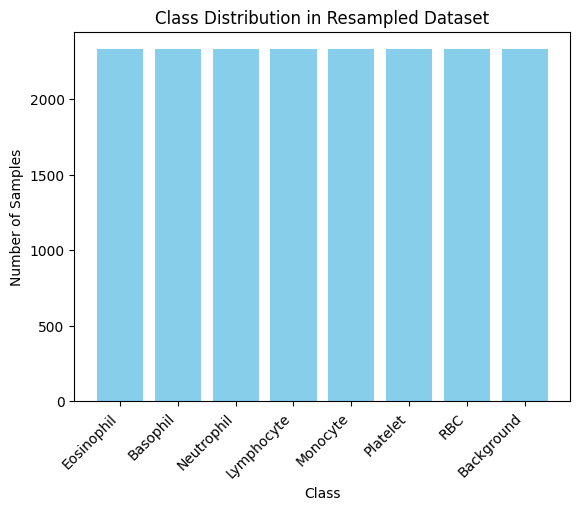

In [ ]:
images = []
labels = []

for img, label in train_dataset:
    images.append(img)  # Convert tf.Tensor to NumPy array
    labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the data
images = images.astype('float32') / 255.0

# Define target number of images per class
TARGET_IMAGES_PER_CLASS = 2330

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Separate images and labels for each class
augmented_images = []
augmented_labels = []

# Iterate over each class to balance the dataset
unique_classes = np.unique(labels)
for class_label in unique_classes:
    # Get indices for the current class
    class_indices = np.where(labels == class_label)[0]
    class_images = images[class_indices]
    num_current_images = len(class_images)

    # If the class already has enough images, skip augmentation
    if num_current_images >= TARGET_IMAGES_PER_CLASS:
        augmented_images.extend(class_images)
        augmented_labels.extend([class_label] * num_current_images)
        continue

    # Calculate the number of images to generate
    num_to_generate = TARGET_IMAGES_PER_CLASS - num_current_images
    print(f"Generating {num_to_generate} images for class {label_name(class_label)}...")

    # Counter to track the number of augmented images for this class
    class_augmented_count = 0

    # Reshape images for ImageDataGenerator and augment
    for image in class_images:
        image_reshaped = image.reshape((1,) + image.shape)  # Reshape for ImageDataGenerator
        for batch in datagen.flow(image_reshaped, batch_size=1):
            augmented_images.append(batch[0].squeeze())  # Save augmented image
            augmented_labels.append(class_label)  # Save corresponding label
            class_augmented_count += 1  # Increment counter for this class
            if class_augmented_count >= num_to_generate:  # Stop when target reached
                break
        if class_augmented_count >= num_to_generate:  # Break outer loop as well
            break

    # Append original images for this class
    augmented_images.extend(class_images)
    augmented_labels.extend([class_label] * num_current_images)
    print(f"Augmentation complete for class {label_name(class_label)}.")

# Convert augmented images and labels to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"Augmentation complete. Total images: {len(augmented_images)}")

# Verify class distribution
import matplotlib.pyplot as plt
from collections import Counter

all_labels = []
for label in augmented_labels:
  all_labels.append(label_name(label))

# Count class distribution
class_counts = Counter(all_labels)
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Resampled Dataset')
plt.show()

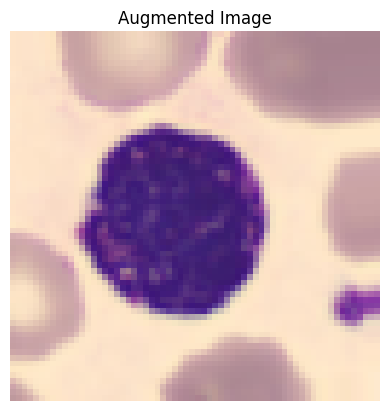

In [ ]:
import random
# Select a random augmented image and its label
random_index = random.randint(0, len(images) - 1)
sample_image = augmented_images[random_index]
sample_label = augmented_labels[random_index]

# Plot the image
plt.imshow(sample_image)
plt.title(f"Augmented Image")
plt.axis('off')  # Remove axes for better visualization
plt.show()

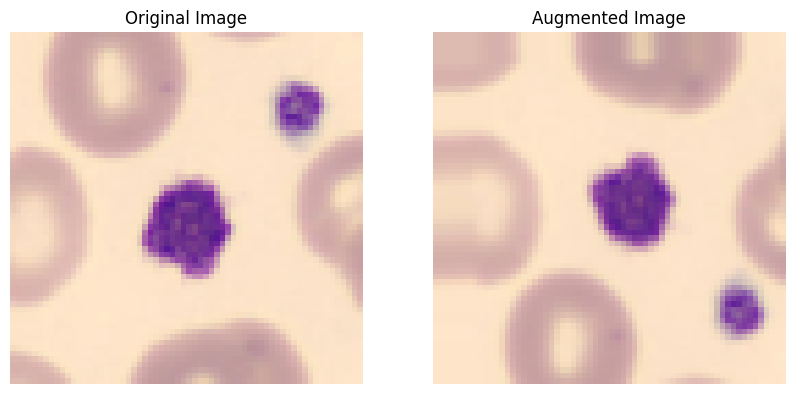

In [ ]:
# Plot an example of the data augmentation
plt.figure(figsize=(10, 5))

# Display Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Display Augmented Image
plt.subplot(1, 2, 2)
plt.imshow(batch[0])
plt.title('Augmented Image')
plt.axis('off')

plt.show()

In [ ]:
# Count instances per class
class_counts = Counter(all_labels)
print("Class Counts train dataset:", class_counts)

# Calculate proportions
classes, counts = zip(*sorted(class_counts.items()))
total_samples = sum(counts)
class_proportions = {cls: count / total_samples for cls, count in class_counts.items()}
print("Class Proportions:", class_proportions)

# Class ratio
largest_class = max(counts)
smallest_class = min(counts)
class_ratio = largest_class / smallest_class
print(f"Class Ratio (Largest:Smallest) = {class_ratio:.2f}")

Class Counts train dataset: Counter({'RBC': 2330, 'Basophil': 2181, 'Lymphocyte': 2026, 'Eosinophil': 1680, 'Neutrophil': 1680, 'Monocyte': 1680, 'Platelet': 1680, 'Background': 1680})
Class Proportions: {'Eosinophil': 0.11247238401285399, 'Basophil': 0.14601325567383008, 'Neutrophil': 0.11247238401285399, 'Lymphocyte': 0.13563633929169178, 'Monocyte': 0.11247238401285399, 'Platelet': 0.11247238401285399, 'RBC': 0.1559884849702082, 'Background': 0.11247238401285399}
Class Ratio (Largest:Smallest) = 1.39


In [ ]:
# Create a TensorFlow dataset from the augmented images and labels
train_dataset = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
train_tf_dataset = create_tf_dataset(train_dataset)
train_tf_dataset = train_tf_dataset.shuffle(buffer_size=1000)
train_tf_dataset = train_tf_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

## Resampling using SMOTE

In [ ]:
images = []
labels = []

# Collect images and labels
for img, label in train_dataset:
    images.append(img)
    labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

images_reshaped = images.reshape(images.shape[0], -1)

# Apply SMOTE for balancing the dataset
# sampling_strategy = {
#     0: int(class_counts[0] * 0.5),  # Original count for Eosinophil
#     1: int(class_counts[1] * 0.5),  # Original count for Basophil
#     2: int(class_counts[2] * 0.5),  # Original count for Neutrophil
#     3: int(class_counts[3] * 0.5),  # Original count for Lymphocyte
#     4: int(class_counts[4] * 0.5),  # Original count for Monocyte
#     5: int(class_counts[5] * 0.5),  # Original count for Platelet
#     6: int(class_counts[6] * 0.5),  # Original count for RBC
#     7: int(class_counts[7] * 0.5)  # Original count for Background
# }
# smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
smote = SMOTE(random_state=42)
train_images_resampled, train_labels_resampled = smote.fit_resample(images_reshaped, labels)

train_images_resampled = train_images_resampled.reshape(train_images_resampled.shape[0], 64, 64, 3) # Reshape back to (num_samples, 64, 64, 3)

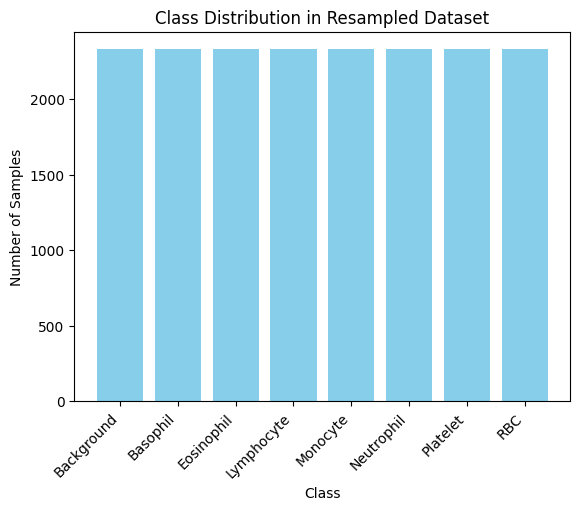

In [ ]:
all_labels_train_resampled = []
for label in train_labels_resampled:
  all_labels_train_resampled.append(label_name(label))

# Count occurrences of each label (class) in the resampled dataset
unique_labels, label_counts = np.unique(all_labels_train_resampled, return_counts=True)

# Plot class distribution of the resampled dataset
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Resampled Dataset')
plt.xticks(unique_labels)  # Label x-axis with class names if needed
plt.show()

In [ ]:
# Create a TensorFlow dataset from the resampled images and labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_resampled, train_labels_resampled))
train_tf_dataset = create_tf_dataset(train_dataset)
train_tf_dataset = train_tf_dataset.map(preprocess_image)
train_tf_dataset = train_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Count instances per class
class_counts = Counter(train_labels_resampled)
print("Class Counts train dataset:", class_counts)

# Calculate proportions
classes, counts = zip(*sorted(class_counts.items()))
total_samples = sum(counts)
class_proportions = {cls: count / total_samples for cls, count in class_counts.items()}
print("Class Proportions:", class_proportions)

# Class ratio
largest_class = max(counts)
smallest_class = min(counts)
class_ratio = largest_class / smallest_class
print(f"Class Ratio (Largest:Smallest) = {class_ratio:.2f}")

Class Counts train dataset: Counter({7: 2330, 3: 2330, 6: 2330, 2: 2330, 1: 2330, 5: 2330, 0: 2330, 4: 2330})
Class Proportions: {7: 0.125, 3: 0.125, 6: 0.125, 2: 0.125, 1: 0.125, 5: 0.125, 0: 0.125, 4: 0.125}
Class Ratio (Largest:Smallest) = 1.00


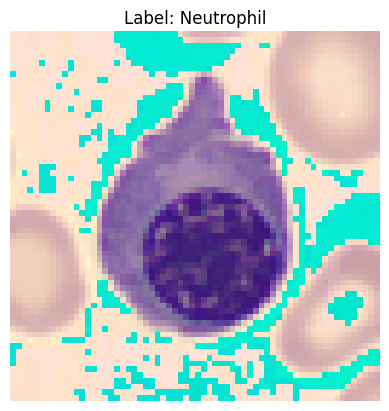

In [ ]:
# Pick an index of a generated image
index = 14000

# Extract the image and label
generated_image = train_images_resampled[index]
generated_label = train_labels_resampled[index]

# Plot the image
plt.imshow(generated_image.astype('uint8'))  # Convert to uint8 if pixel values are not in range [0, 255]
plt.title(f"Label: {label_name(generated_label)}")
plt.axis('off')  # Hide axes for better visualization
plt.show()

# CNN

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the CNN model
model = cnn(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_conv (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_bn (BatchNormalization)            │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_activation (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_conv (Conv2D)                      │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_bn (BatchNormalization)            │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_activation (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_conv (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_bn (BatchNormalization)            │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_activation (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_conv (Conv2D)                      │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_bn (BatchNormalization)            │ (None, 64, 64, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_activation (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,778,952 (33.49 MB)

 Trainable params: 8,777,992 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 71s 268ms/step - accuracy: 0.5800 - loss: 69.3082 - val_accuracy: 0.1373 - val_loss: 101.6419
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - accuracy: 0.8515 - loss: 4.8424 - val_accuracy: 0.2377 - val_loss: 67.0959
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - accuracy: 0.8964 - loss: 3.3713 - val_accuracy: 0.7880 - val_loss: 9.7426
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - accuracy: 0.9079 - loss: 3.1201 - val_accuracy: 0.8849 - val_loss: 7.1433
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9229 - loss: 2.5314 - val_accuracy: 0.9194 - val_loss: 3.0507
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9324 - loss: 2.1873 - val_accuracy: 0.6968 - val_loss: 13.2385
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9453 - loss: 1.6387 - val_accuracy: 0.8645 - val_loss: 5.8960
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9444 - lo

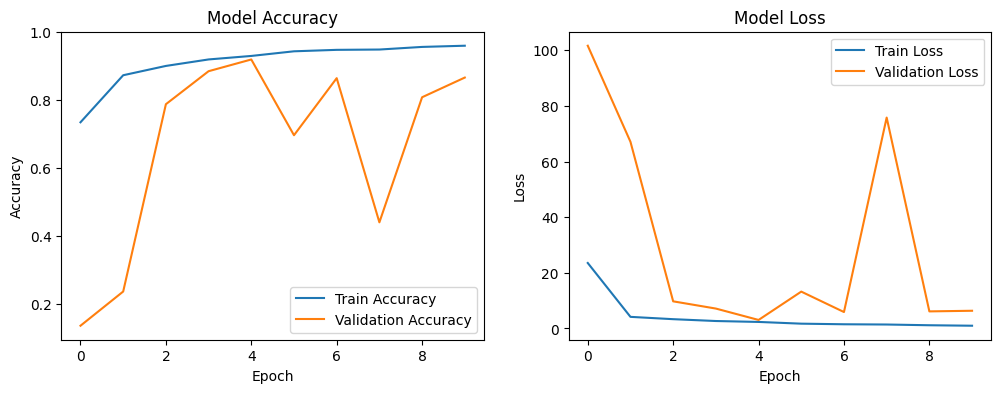

In [ ]:
# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
# Save the model
model.save('pre-trained/cnn.keras')

## Performance assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/cnn.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
Test F1 Score: 0.8618


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.45      1.00      0.62       244
           1       1.00      0.97      0.98       624
           2       0.99      0.86      0.92       311
           3       0.79      0.58      0.67       579
           4       0.98      0.73      0.84       243
           5       0.95      0.67      0.78       284
           6       0.89      0.96      0.92       666
           7       1.00      1.00      1.00       470

    accuracy                           0.86      3421
   macro avg       0.88      0.85      0.84      3421
weighted avg       0.90      0.86      0.86      3421



# Dilated CNN

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the Dilated CNN model
model = dilated_cnn(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "dilated_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_conv (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_bn (BatchNormalization)            │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_activation (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_conv (Conv2D)                      │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_bn (BatchNormalization)            │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_activation (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_conv (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_bn (BatchNormalization)            │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_activation (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_conv (Conv2D)                      │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_bn (BatchNormalization)            │ (None, 64, 64, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_activation (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,778,952 (33.49 MB)

 Trainable params: 8,777,992 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 73s 302ms/step - accuracy: 0.5909 - loss: 87.6317 - val_accuracy: 0.1373 - val_loss: 345.4749
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 186ms/step - accuracy: 0.8613 - loss: 7.5676 - val_accuracy: 0.5561 - val_loss: 45.4186
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 194ms/step - accuracy: 0.8810 - loss: 5.9105 - val_accuracy: 0.8353 - val_loss: 8.1636
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 34s 184ms/step - accuracy: 0.9086 - loss: 3.8505 - val_accuracy: 0.7366 - val_loss: 16.1456
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.9224 - loss: 2.3141 - val_accuracy: 0.3984 - val_loss: 141.7865
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.9094 - loss: 3.1283 - val_accuracy: 0.9258 - val_loss: 2.0622
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 196ms/step - accuracy: 0.9277 - loss: 1.7935 - val_accuracy: 0.8236 - val_loss: 6.5071
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 184ms/step - accuracy: 0.9398 - 

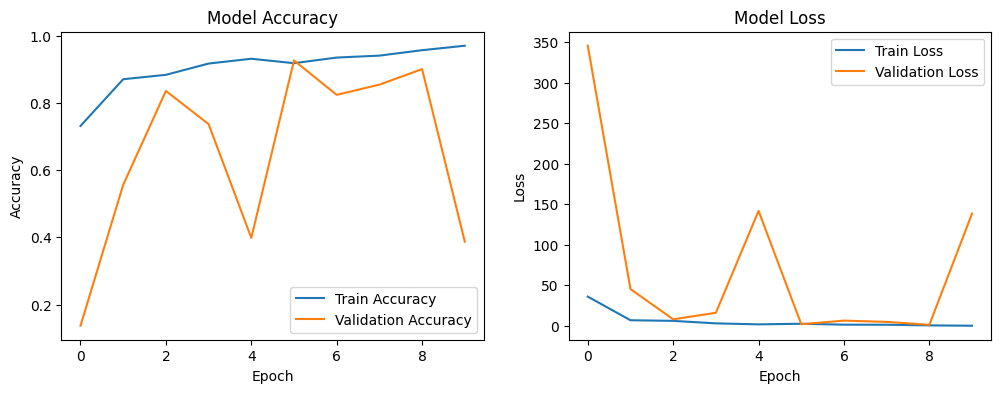

In [ ]:
# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
# Save the model
model.save('pre-trained/dilated_cnn.keras')

## Performance assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/dilated_cnn.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step
Test F1 Score: 0.3518


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.66      0.75       244
           1       0.27      1.00      0.43       624
           2       0.33      0.45      0.38       311
           3       0.71      0.24      0.36       579
           4       1.00      0.02      0.03       243
           5       0.88      0.12      0.22       284
           6       0.85      0.27      0.40       666
           7       0.67      0.11      0.19       470

    accuracy                           0.39      3421
   macro avg       0.70      0.36      0.35      3421
weighted avg       0.66      0.39      0.35      3421



# ResNet

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the ResNet model
model = resnet34(input_shape = input_shape)

# Print the model summary
model.summary()

Model: "resnet34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 70, 70, 3)      │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 35, 35, 64)     │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 35, 35, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 35, 35, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 18, 18, 64)     │              0 │ activation_8[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 18, 18, 64)     │         36,928 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 18, 18, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 18, 18, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 18, 18, 64)     │         36,928 │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 18, 18, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 18, 18, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 18, 18, 64)     │              0 │ add[0][0]              │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 18, 18, 64)     │         36,928 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 18, 18, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,323,016 (81.34 MB)

 Trainable params: 21,307,784 (81.28 MB)

 Non-trainable params: 15,232 (59.50 KB)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 54s 174ms/step - accuracy: 0.5055 - loss: 1.6546 - val_accuracy: 0.1040 - val_loss: 2.5966
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.8327 - loss: 0.4674 - val_accuracy: 0.1513 - val_loss: 3.3046
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.8990 - loss: 0.2817 - val_accuracy: 0.8207 - val_loss: 0.4777
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9477 - loss: 0.1635 - val_accuracy: 0.8984 - val_loss: 0.2961
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.9859 - loss: 0.0805 - val_accuracy: 0.8674 - val_loss: 0.4241
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.9976 - loss: 0.0403 - val_accuracy: 0.8464 - val_loss: 0.5288
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9998 - loss: 0.0240 - val_accuracy: 0.8353 - val_loss: 0.5968
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 1.0000 - loss: 0.0167 -

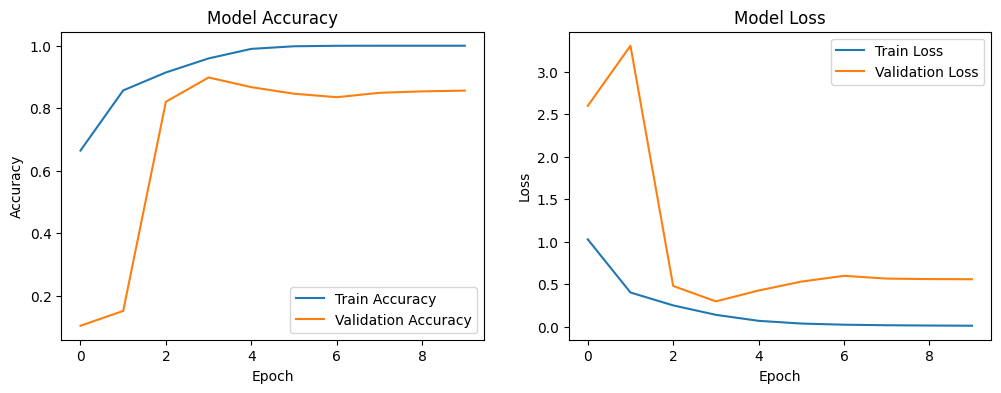

In [ ]:
# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
# Save the model
model.save('pre-trained/resnet.keras')

## Performance assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/resnet.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step
Test F1 Score: 0.8362


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.56      0.97      0.71       244
           1       0.89      0.99      0.94       624
           2       0.98      0.74      0.84       311
           3       0.70      0.63      0.66       579
           4       0.92      0.69      0.79       243
           5       0.96      0.53      0.68       284
           6       0.86      0.96      0.91       666
           7       1.00      0.99      0.99       470

    accuracy                           0.84      3421
   macro avg       0.86      0.81      0.82      3421
weighted avg       0.86      0.84      0.84      3421



# VGG

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_conv (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_conv (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_bn (BatchNormalization)          │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_activation (Activation)          │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_conv (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_bn (BatchNormalization)          │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_activation (Activation)          │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,564,712 (36.49 MB)

 Trainable params: 9,562,792 (36.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 115s 474ms/step - accuracy: 0.5744 - loss: 21.7064 - val_accuracy: 0.1373 - val_loss: 15.9833
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 346ms/step - accuracy: 0.8721 - loss: 0.8558 - val_accuracy: 0.1571 - val_loss: 12.3775
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 348ms/step - accuracy: 0.9222 - loss: 0.3491 - val_accuracy: 0.6799 - val_loss: 2.0569
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.9582 - loss: 0.1561 - val_accuracy: 0.9252 - val_loss: 0.2763
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.9742 - loss: 0.0838 - val_accuracy: 0.9509 - val_loss: 0.1684
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 347ms/step - accuracy: 0.9819 - loss: 0.0576 - val_accuracy: 0.9556 - val_loss: 0.1467
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 84s 357ms/step - accuracy: 0.9908 - loss: 0.0329 - val_accuracy: 0.9585 - val_loss: 0.1418
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 357ms/step - accuracy: 0.9964 - los

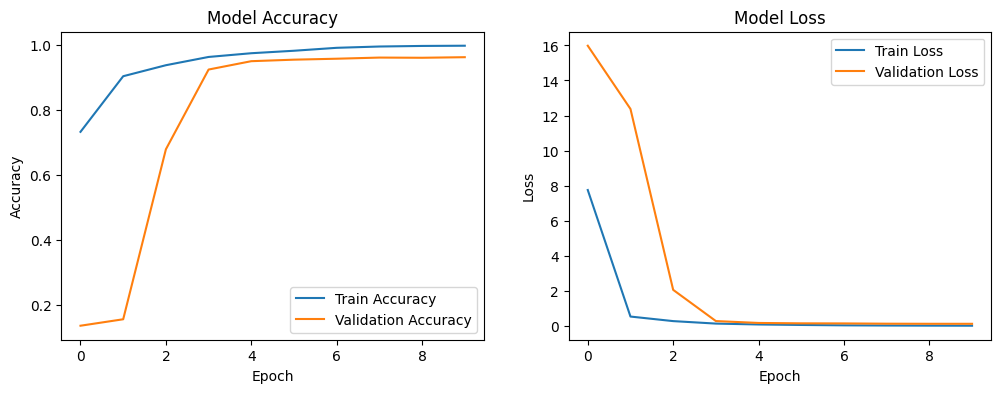

In [ ]:
# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
# Save the model
model.save('pre-trained/vgg.keras')

## Performance assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/vgg.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step
Test F1 Score: 0.9627


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       244
           1       0.99      0.99      0.99       624
           2       0.98      0.94      0.96       311
           3       0.90      0.96      0.93       579
           4       0.94      0.98      0.96       243
           5       0.96      0.90      0.93       284
           6       0.97      0.95      0.96       666
           7       1.00      1.00      1.00       470

    accuracy                           0.96      3421
   macro avg       0.96      0.96      0.96      3421
weighted avg       0.96      0.96      0.96      3421



# Autoencoder

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the autoencoder model
encoder, decoder, model = autoencoder(input_shape=input_shape)

# Print the model summary
encoder.summary()
decoder.summary()
model.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_conv (Conv2D)              │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_activation (Activation)    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_conv (Conv2D)              │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_activation (Activation)    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_conv (Conv2D)              │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_bn (BatchNormalization)    │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_activation (Activation)    │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_conv (Conv2D)              │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_bn (BatchNormalization)    │ (None, 64, 64, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_activation (Activation)    │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_output (Dense)                │ (None, 32)                  │      33,554,464 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,944,800 (129.49 MB)

 Trainable params: 33,943,840 (129.49 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4096)                │         135,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 523,331 (2.00 MB)

 Trainable params: 523,331 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 32)                  │      33,944,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 64, 64, 3)           │         523,331 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,468,131 (131.49 MB)

 Trainable params: 34,467,171 (131.48 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - loss: 0.1955 - mae: 0.2773 - val_loss: 0.0214 - val_mae: 0.1147
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 62s 151ms/step - loss: 0.0111 - mae: 0.0794 - val_loss: 0.0155 - val_mae: 0.1001
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - loss: 0.0092 - mae: 0.0713 - val_loss: 0.0163 - val_mae: 0.1037
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - loss: 0.0081 - mae: 0.0661 - val_loss: 0.0108 - val_mae: 0.0813
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 30s 163ms/step - loss: 0.0076 - mae: 0.0637 - val_loss: 0.0076 - val_mae: 0.0645
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - loss: 0.0071 - mae: 0.0611 - val_loss: 0.0073 - val_mae: 0.0621
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - loss: 0.0069 - mae: 0.0601 - val_loss: 0.0069 - val_mae: 0.0606
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - loss: 0.0066 - mae: 0.0588 - val_loss: 0.0067 - val_mae: 0.0595
Epoch 9/10
186/186 ━━━━━━━━━━━━━

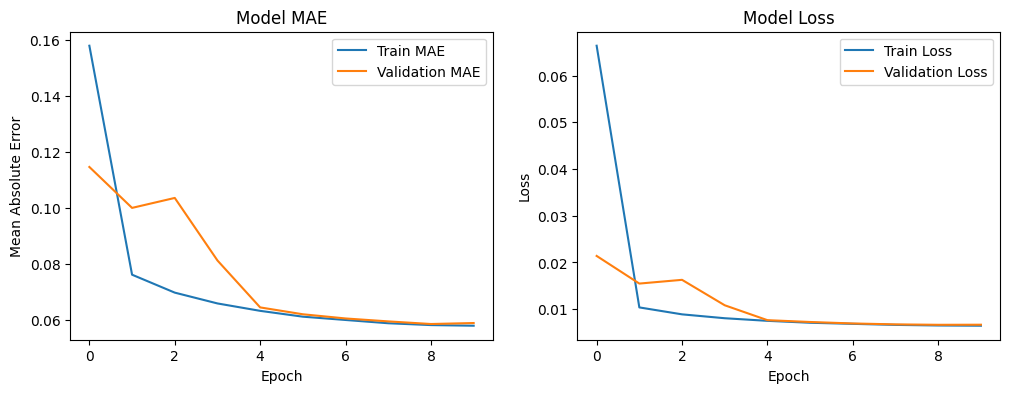

In [ ]:
# Train the autoencoder
trained_model, history = train_autoencoder(
    model=model,
    train_dataset=train_autoencoder_dataset,
    val_dataset=val_autoencoder_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
# Save the encoder and decoder
encoder.save('pre-trained/encoder.keras')
decoder.save('pre-trained/decoder.keras')

In [ ]:
# If necessary, load the encoder and decoder
encoder = load_model('pre-trained/encoder.keras')
decoder = load_model('pre-trained/decoder.keras')

In [ ]:
# Detach the decoder and add a CNN-like architecture
model = autoclassifier(encoder)

# Print the model summary
model.summary()

Model: "autoclassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_conv (Conv2D)              │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_activation (Activation)    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_conv (Conv2D)              │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_activation (Activation)    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_conv (Conv2D)              │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_bn (BatchNormalization)    │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_activation (Activation)    │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_conv (Conv2D)              │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_bn (BatchNormalization)    │ (None, 64, 64, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_activation (Activation)    │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_output (Dense)                │ (None, 32)                  │      33,554,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ class_1_conv (Conv2D)                │ (None, 4, 4, 64)            │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 34,037,032 (129.84 MB)

 Trainable params: 91,848 (358.78 KB)

 Non-trainable params: 33,945,184 (129.49 MB)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.5800 - loss: 1.1845 - val_accuracy: 0.6653 - val_loss: 0.8837 - learning_rate: 0.0010
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - accuracy: 0.7315 - loss: 0.7446 - val_accuracy: 0.7623 - val_loss: 0.6660 - learning_rate: 9.0484e-04
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7616 - loss: 0.6637 - val_accuracy: 0.7518 - val_loss: 0.6649 - learning_rate: 7.4082e-04
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7828 - loss: 0.6014 - val_accuracy: 0.7401 - val_loss: 0.6913 - learning_rate: 5.4881e-04
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8012 - loss: 0.5495 - val_accuracy: 0.7687 - val_loss: 0.6359 - learning_rate: 3.6788e-04
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8143 - loss: 0.5122 - val_accuracy: 0.8020 - val_loss: 0.5589 - learning_rate: 2.2313e-04
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step -

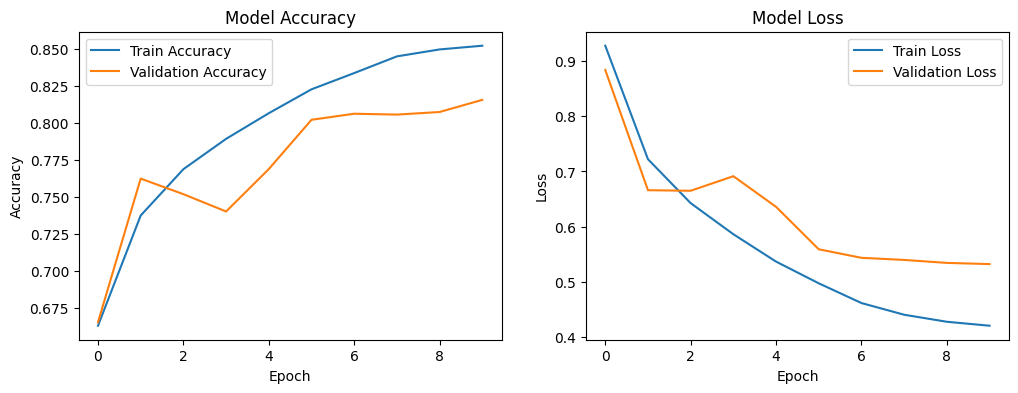

In [ ]:
# Train the resulting classifier
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
# Save the model
model.save('pre-trained/autoclassifier.keras')

## Performance assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/autoclassifier.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
Test F1 Score: 0.7594


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       244
           1       0.71      0.91      0.80       624
           2       0.95      0.59      0.72       311
           3       0.63      0.67      0.65       579
           4       0.62      0.92      0.74       243
           5       0.79      0.33      0.46       284
           6       0.89      0.80      0.84       666
           7       0.99      1.00      0.99       470

    accuracy                           0.77      3421
   macro avg       0.78      0.74      0.73      3421
weighted avg       0.79      0.77      0.76      3421



# Inception


In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the Inception model
model = inception(input_shape=input_shape)

# Print the model summary
model.summary()

In [ ]:
# Train the model using SGD
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/inception.keras')

## Performance assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/inception.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

# Feature extraction



In [ ]:
#Load all the models
model_cnn = load_model('pre-trained/cnn.keras')
model_vgg18 = load_model('pre-trained/vgg18.keras')
model_autoclassifier = load_model('pre-trained/autoclassifier.keras')
model_resnet = load_model('pre-trained/resnet.keras')
model_inception = load_model('pre-trained/inception.keras')

In [ ]:
# Take the last convolution layer for each model
last_layer_cnn = "4_conv"
last_layer_vgg18 = "6_3_conv"
last_layer_autoclassifier = "class_2_conv"
last_layer_resnet = "conv2d_35"
last_layer_inception = "concatenate_15"

In [ ]:
# Grad-CAM Function
def get_gradcam_heatmap(model, img_tensor, target_layer_name, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(target_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, class_index[0]]

    # Compute gradients of the target class score w.r.t. the feature maps
    grads = tape.gradient(loss, conv_outputs)

    # Compute the importance of each feature map channel
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Combine weights with feature maps
    gradcam = tf.reduce_sum(weights * conv_outputs[0], axis=-1)

    # Apply ReLU to the heatmap
    gradcam = tf.nn.relu(gradcam)

    return gradcam.numpy()

# Visualize Grad-CAM
def plot_gradcam(image, heatmap):
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # Normalize to [0,1]
    heatmap = np.uint8(255 * heatmap)  # Scale to [0,255]

    # Apply colormap
    heatmap = tf.keras.preprocessing.image.array_to_img(heatmap[..., np.newaxis])
    heatmap = heatmap.resize((image.shape[1], image.shape[0]))
    heatmap = np.asarray(heatmap)
    heatmap = np.uint8(plt.cm.jet(heatmap)[:, :, :3] * 255)

    # Superimpose heatmap on original image
    superimposed_img = heatmap * 0.4 + image
    return superimposed_img

In [ ]:
# Shuffle the dataset in order to get a random image from the dataset
test_tf_dataset = test_tf_dataset.shuffle(buffer_size=1000)

# Use Grad-CAM on a sample image
sample_img, sample_label = next(iter(test_tf_dataset.take(1)))  # Get a batch
sample_img = sample_img[0:1]  # Select one image

# Get the heatmap
# For the cnn
target_layer_name = last_layer_cnn
target_layer = model_cnn.get_layer(target_layer_name)
pred_class = model_cnn.predict(sample_img).argmax(axis=-1)
heatmap_cnn = get_gradcam_heatmap(model_cnn, sample_img, target_layer_name, pred_class)
# For the vgg15
target_layer_name = last_layer_vgg18
target_layer = model_vgg18.get_layer(target_layer_name)
pred_class = model_vgg18.predict(sample_img).argmax(axis=-1)
heatmap_vgg18 = get_gradcam_heatmap(model_vgg18, sample_img, target_layer_name, pred_class)
# For the autoclassifier
target_layer_name = last_layer_autoclassifier
target_layer = model_autoclassifier.get_layer(target_layer_name)
pred_class = model_autoclassifier.predict(sample_img).argmax(axis=-1)
heatmap_autoclassifier = get_gradcam_heatmap(model_autoclassifier, sample_img, target_layer_name, pred_class)
# For the resnet
target_layer_name = last_layer_resnet
target_layer = model_resnet.get_layer(target_layer_name)
pred_class = model_resnet.predict(sample_img).argmax(axis=-1)
heatmap_resnet = get_gradcam_heatmap(model_resnet, sample_img, target_layer_name, pred_class)
# For the inception
target_layer_name = last_layer_inception
target_layer = model_inception.get_layer(target_layer_name)
pred_class = model_inception.predict(sample_img).argmax(axis=-1)
heatmap_inception = get_gradcam_heatmap(model_inception, sample_img, target_layer_name, pred_class)

plt.figure(figsize=(30, 10))

# Display the original image
plt.subplot(1, 6, 1)
plt.imshow(sample_img[0])  # Display the original image
plt.axis("off")
plt.title('Original Image')

# Display the Grad-CAM heatmap for the cnn
plt.subplot(1, 6, 2)
plt.imshow(plot_gradcam(sample_img[0].numpy(), heatmap_cnn))
plt.axis("off")
plt.title('CNN')

# Display the Grad-CAM heatmap for the vgg18
plt.subplot(1, 6, 3)
plt.imshow(plot_gradcam(sample_img[0].numpy(), heatmap_vgg18))
plt.axis("off")
plt.title('VGG18')

# Display the Grad-CAM heatmap for the autoclassifier
plt.subplot(1, 6, 4)
plt.imshow(plot_gradcam(sample_img[0].numpy(), heatmap_autoclassifier))
plt.axis("off")
plt.title('Autoclassifier')

# Display the Grad-CAM heatmap for the ResNet
plt.subplot(1, 6, 5)
plt.imshow(plot_gradcam(sample_img[0].numpy(), heatmap_resnet))
plt.axis("off")
plt.title('ResNet')

# Display the Grad-CAM heatmap for the cnn
plt.subplot(1, 6, 6)
plt.imshow(plot_gradcam(sample_img[0].numpy(), heatmap_inception))
plt.axis("off")
plt.title('Inception')

plt.show()

NameError: name 'last_layer_cnn' is not defined

# Deep Analysis of VGG-like architecture

## VGG12

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg12(input_shape=input_shape)

# Print the model summary
model.summary()

ImportError: cannot import name 'preprocessing' from 'tensorflow.keras.layers' (/usr/local/lib/python3.10/dist-packages/keras/_tf_keras/keras/layers/__init__.py)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.4009 - loss: 1.6945 - val_accuracy: 0.1373 - val_loss: 2.4262 - learning_rate: 0.0010
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.7792 - loss: 0.6551 - val_accuracy: 0.1373 - val_loss: 3.2261 - learning_rate: 9.0484e-04
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8348 - loss: 0.4776 - val_accuracy: 0.5134 - val_loss: 1.2953 - learning_rate: 7.4082e-04
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8611 - loss: 0.3951 - val_accuracy: 0.8896 - val_loss: 0.3008 - learning_rate: 5.4881e-04
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8770 - loss: 0.3610 - val_accuracy: 0.9153 - val_loss: 0.2448 - learning_rate: 3.6788e-04
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8844 - loss: 0.3320 - val_accuracy: 0.9200 - val_loss: 0.2323 - learning_rate: 2.2313e-04
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - ac

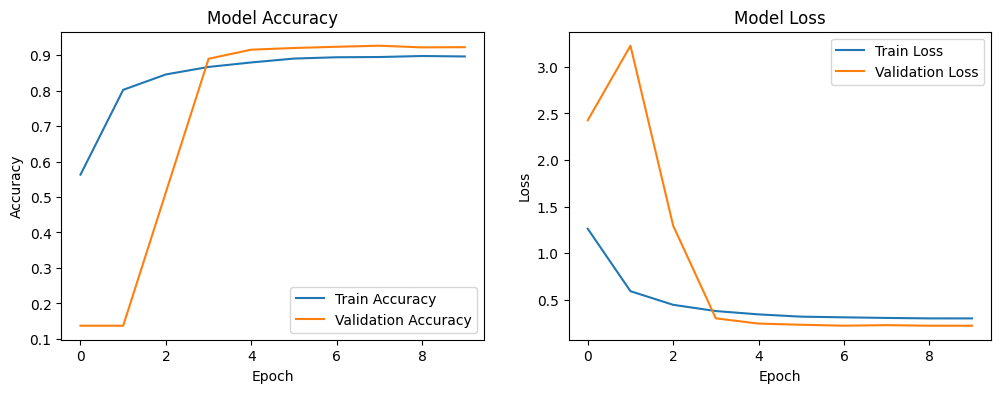

In [ ]:
# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/vgg12.keras')

## VGG15

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg15(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_conv (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_conv (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_conv (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 11,085,352 (42.29 MB)

 Trainable params: 11,079,848 (42.27 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [ ]:
# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=datagen.flow(X_train, Y_train, batch_size=64),
    val_dataset=(X_val, Y_val),
    test_dataset=(X_test, Y_test),
    epochs=15,
    learning_rate=0.001,
    scheduler_enabled=False
)

Epoch 1/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.6790 - loss: 2.0954 - val_accuracy: 0.1373 - val_loss: 2053.5054
Epoch 2/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.5267 - loss: 2.4807 - val_accuracy: 0.1373 - val_loss: 2.8592
Epoch 3/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5131 - loss: 1.4475 - val_accuracy: 0.1373 - val_loss: 11.3876
Epoch 4/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.5845 - loss: 2.4323 - val_accuracy: 0.1419 - val_loss: 7.4683
Epoch 5/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.5283 - loss: 2.1003 - val_accuracy: 0.1373 - val_loss: 4.2314
Epoch 6/15
 27/146 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.2796 - loss: 3.9501

In [ ]:
model.save('pre-trained/vgg15.keras')

## VGG18

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg18(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_conv (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_conv (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_conv (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,598,056 (63.32 MB)

 Trainable params: 16,589,480 (63.28 MB)

 Non-trainable params: 8,576 (33.50 KB)

Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.6607 - loss: 1.0978 - val_accuracy: 0.1373 - val_loss: 2.1535
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.4712 - loss: 1.6187 - val_accuracy: 0.1373 - val_loss: 2.3979
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.4891 - loss: 1.5432 - val_accuracy: 0.1373 - val_loss: 2.6769
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.5255 - loss: 1.4311 - val_accuracy: 0.2039 - val_loss: 2.5732
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.5814 - loss: 1.2989 - val_accuracy: 0.3914 - val_loss: 2.4476
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.6353 - loss: 1.1579 - val_accuracy: 0.3610 - val_loss: 2.8397
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.6730 - loss: 1.0524 - val_accuracy: 0.3727 - val_loss: 3.0486
Epoch 8/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.6997 - loss: 0.9587 -

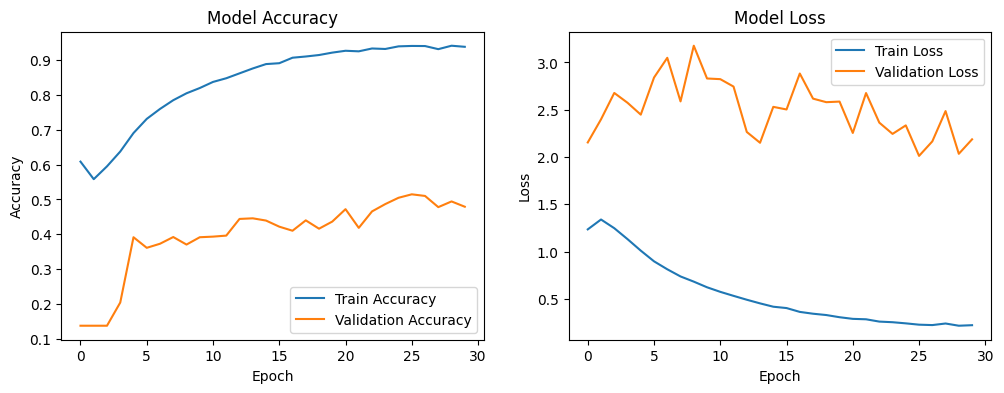

In [ ]:
# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=30,
    learning_rate=0.001,
    scheduler_enabled=False
)

In [ ]:
augmented_images

In [ ]:
model.save('pre-trained/vgg18.keras')

### Performance assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/vgg18.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

KeyboardInterrupt: 